## Analytic and MC-based Expected Improvement (EI) acquisition

In this tutorial, we compare the analytic and MC-based EI acquisition functions and show both `scipy`- and `torch`-based optimizers for optimizing the acquisition. This tutorial highlights the modularity of botorch and the ability to easily try different acquisition functions and accompanying optimization algorithms on the same fitted model.

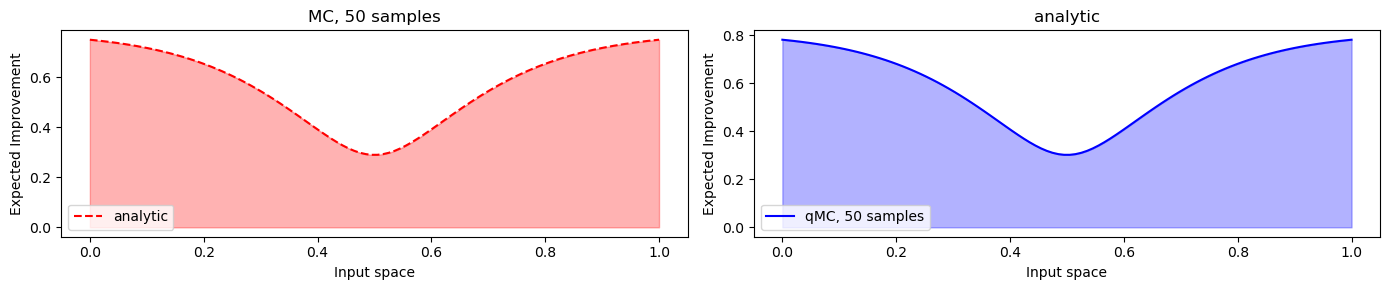

In [18]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler
from matplotlib import pyplot as plt

# Training data: single point at 0.5
train_X = torch.tensor([[0.5]], dtype=torch.float64)
train_Y = torch.tensor([[0.0]], dtype=torch.float64)  # Assume a zero observation for illustration

# Set up the GP model
gp_model = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_mll(mll)

# Define the analytic Expected Improvement (EI) acquisition function
best_f = train_Y.max().item()
EI = ExpectedImprovement(model=gp_model, best_f=best_f)

# Define the MC Expected Improvement (qEI) acquisition function
sampler = SobolQMCNormalSampler(torch.Size([50]))
qEI = qExpectedImprovement(model=gp_model, best_f=best_f, sampler=sampler)

# Evaluate the acquisition functions over the domain [0,1]
X_test = torch.linspace(0, 1, 100).unsqueeze(-1).unsqueeze(-1)
EI_vals = EI(X_test)
qEI_vals = qEI(X_test)

# Flatten X_test for plotting
X_test = X_test.view(-1).detach()

# Plot the results
plt.figure(figsize=(14, 3))
plt.subplot(1, 2, 1)
plt.plot(X_test.numpy(), EI_vals.detach().numpy(), 'r--', label='analytic')
plt.fill_between(X_test.numpy().ravel(), EI_vals.detach().numpy().ravel(), color='red', alpha=0.3)
plt.title("MC, 50 samples")

plt.subplot(1, 2, 2)
plt.plot(X_test.numpy(), qEI_vals.detach().numpy(), 'b-', label='qMC, 50 samples')
plt.fill_between(X_test.numpy().ravel(), qEI_vals.detach().numpy().ravel(), color='blue', alpha=0.3)
plt.title("analytic")

for ax in plt.gcf().axes:
    ax.legend()
    ax.set_xlabel('Input space')
    ax.set_ylabel('Expected Improvement')

plt.tight_layout()
plt.show()


### Comparison of analytic and MC-based EI

In [1]:
import torch

from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.test_functions import Hartmann
from gpytorch.mlls import ExactMarginalLogLikelihood

neg_hartmann6 = Hartmann(dim=6, negate=True)

First, we generate some random data and fit a SingleTaskGP for a 6-dimensional synthetic test function 'Hartmann6'.

In [3]:
from botorch.acquisition import ExpectedImprovement

best_value = train_obj.max()
EI = ExpectedImprovement(model=model, best_f=best_value)

In [2]:
train_x = torch.rand(10, 6, dtype=torch.float64)
train_obj = neg_hartmann6(train_x).unsqueeze(-1)
model = SingleTaskGP(train_X=train_x, train_Y=train_obj, outcome_transform=Standardize(m=1))
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll);

Initialize an analytic EI acquisition function on the fitted model.


Next, we optimize the analytic EI acquisition function using 50 random restarts chosen from 100 initial raw samples.

In [4]:
from botorch.optim import optimize_acqf

new_point_analytic, _ = optimize_acqf(
    acq_function=EI,
    bounds=torch.tensor([[0.0] * 6, [1.0] * 6]),
    q=1,
    num_restarts=20,
    raw_samples=100,
    options={},
)

In [5]:
new_point_analytic

tensor([[0.6483, 0.1735, 0.1188, 0.2841, 0.2902, 1.0000]])

Now, let's swap out the analytic acquisition function and replace it with an MC version. Note that we are in the `q = 1` case; for `q > 1`, an analytic version does not exist.

In [6]:
from botorch.acquisition import qExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler


sampler = SobolQMCNormalSampler(sample_shape=torch.Size([512]), seed=0)
MC_EI = qExpectedImprovement(model, best_f=best_value, sampler=sampler)
torch.manual_seed(seed=0)  # to keep the restart conditions the same
new_point_mc, _ = optimize_acqf(
    acq_function=MC_EI,
    bounds=torch.tensor([[0.0] * 6, [1.0] * 6]),
    q=1,
    num_restarts=20,
    raw_samples=100,
    options={},
)

In [7]:
new_point_mc

tensor([[0.6483, 0.1735, 0.1188, 0.2841, 0.2902, 1.0000]])

Check that the two generated points are close.

In [8]:
torch.norm(new_point_mc - new_point_analytic)

tensor(1.8178e-05)

### Using a torch optimizer on a stochastic acquisition function

We could also optimize using a `torch` optimizer. This is particularly useful for the case of a stochastic acquisition function, which we can obtain by using a `StochasticSampler`. First, we illustrate the usage of `torch.optim.Adam`. In the code snippet below, `gen_batch_initial_candidates` uses a heuristic to select a set of restart locations, `gen_candidates_torch` is a wrapper to the `torch` optimizer for maximizing the acquisition value, and `get_best_candidates` finds the best result amongst the random restarts.

Under the hood, `gen_candidates_torch` uses a convergence criterion based on exponential moving averages of the loss. 

In [9]:
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.generation import get_best_candidates, gen_candidates_torch
from botorch.optim import gen_batch_initial_conditions

resampler = StochasticSampler(sample_shape=torch.Size([512]))
MC_EI_resample = qExpectedImprovement(model, best_f=best_value, sampler=resampler)
bounds = torch.tensor([[0.0] * 6, [1.0] * 6])

batch_initial_conditions = gen_batch_initial_conditions(
    acq_function=MC_EI_resample,
    bounds=bounds,
    q=1,
    num_restarts=20,
    raw_samples=100,
)


In [11]:
batch_initial_conditions.shape, batch_initial_conditions

(torch.Size([20, 1, 6]),
 tensor([[[0.8423, 0.8282, 0.2040, 0.4235, 0.9081, 0.8421]],
 
         [[0.5986, 0.4484, 0.1572, 0.4830, 0.3692, 0.9085]],
 
         [[0.0678, 0.2829, 0.6101, 0.1615, 0.2763, 0.5611]],
 
         [[0.5737, 0.7141, 0.0498, 0.3629, 0.1554, 0.0502]],
 
         [[0.1228, 0.4216, 0.9470, 0.4853, 0.6851, 0.2804]],
 
         [[0.7005, 0.0134, 0.8543, 0.0499, 0.6567, 0.5269]],
 
         [[0.6661, 0.0926, 0.4036, 0.4496, 0.0707, 0.3730]],
 
         [[0.1144, 0.7660, 0.4892, 0.9863, 0.8994, 0.1742]],
 
         [[0.1283, 0.5114, 0.3597, 0.6302, 0.2635, 0.3247]],
 
         [[0.7590, 0.2996, 0.4093, 0.7751, 0.9492, 0.6767]],
 
         [[0.9365, 0.4590, 0.3743, 0.2641, 0.8658, 0.5165]],
 
         [[0.3524, 0.0357, 0.7926, 0.2996, 0.3782, 0.6116]],
 
         [[0.2813, 0.8514, 0.3264, 0.0788, 0.6391, 0.6303]],
 
         [[0.4854, 0.9569, 0.8494, 0.9299, 0.2140, 0.3195]],
 
         [[0.1603, 0.9105, 0.9679, 0.0260, 0.4509, 0.8594]],
 
         [[0.5277, 0.1812, 0.3

In [ ]:
batch_candidates, batch_acq_values = gen_candidates_torch(
    initial_conditions=batch_initial_conditions,
    acquisition_function=MC_EI_resample,
    lower_bounds=bounds[0],
    upper_bounds=bounds[1],
    optimizer=torch.optim.Adam,
    options={"maxiter": 500},
)
new_point_torch_Adam = get_best_candidates(
    batch_candidates=batch_candidates, batch_values=batch_acq_values
).detach()

In [10]:
new_point_torch_Adam

tensor([[0.1602, 0.0938, 0.3562, 0.4471, 0.3338, 0.6613]])

In [11]:
torch.norm(new_point_torch_Adam - new_point_analytic)

tensor(0.0210)

By changing the `optimizer` parameter to `gen_candidates_torch`, we can also try `torch.optim.SGD`. Note that without the adaptive step size selection of Adam, basic SGD does worse job at optimizing without further manual tuning of the optimization parameters.

In [12]:
batch_candidates, batch_acq_values = gen_candidates_torch(
    initial_conditions=batch_initial_conditions,
    acquisition_function=MC_EI_resample,
    lower_bounds=bounds[0],
    upper_bounds=bounds[1],
    optimizer=torch.optim.SGD,
    options={"maxiter": 500},
)
new_point_torch_SGD = get_best_candidates(
    batch_candidates=batch_candidates, batch_values=batch_acq_values
).detach()

In [13]:
new_point_torch_SGD

tensor([[0.1715, 0.2573, 0.4526, 0.5164, 0.2422, 0.6952]])

In [14]:
torch.norm(new_point_torch_SGD - new_point_analytic)

tensor(0.2180)